# Chignolin MFPTs after clustering
This is a modification of the notebook given Chris (christoph.wehmeyer@fu-berlin.de), in this case we are going to use is to cluster the microstates based on the commute times.

In [1]:
import sys
import math
sys.path.append("/home/Ernesto/Dropbox/workspace/NMpathAnalysis/nmpath")
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

# My modules
from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print 
from IPython.display import Markdown, display

## Auxiliary functions


In [2]:
def get_lagtime_from_array(lags, lagtime, dt=0.2):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()


def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if microstate in macrostates[0]:
                rmsd_cluster0.append(rmsd[j])
            elif (len(macrostates) > 1) and microstate in macrostates[1]:
                rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0,normed=True, bins=25, color="r", 
                 alpha=0.5,label="cluster-0", edgecolor="r")
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()


color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']

## Create a feature reader

We create a feature reader to obtain minimal distances between all residues which are not close neighbours. Feel free to map these distances to binary contacts or use inverse minimal residue distances instead. These coices usually work quite well.

In [3]:
traj_files = [f for f in sorted(glob('../../PathAnalysisShawProteins/CLN025-0-protein/CLN025-0-protein-*.dcd'))]
pdb_file = '../../PathAnalysisShawProteins/CLN025-0-protein/chig_pdb_166.pdb'

features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

08-08-17 17:56:59 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


/home/esuarez/anaconda3/lib/python3.6/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.4, you have 2.3.2.
  .format(latest=latest, current=current), category=UserWarning)


## Discretization and MSM estimation

We start the actual analysis with a TICA projection onto two components on which we perform a k-means clustering. Then, we take a quick view on the implied timescale convergence, the 2D representation, and the clustering:

08-08-17 17:58:03 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 25 steps.


/home/esuarez/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


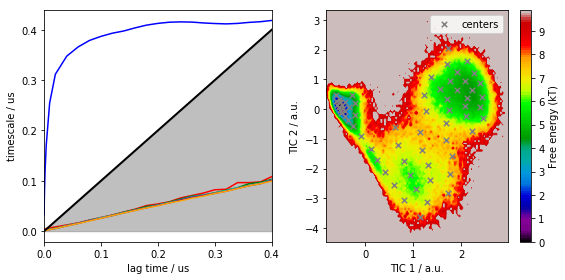

In [4]:
tica = pyemma.coordinates.tica(data=source, lag=5, dim=2).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=64, max_iter=100)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica.T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

# MSM estimation
msm = [pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us') for lag in lags]

## Agglomerative Clustering from the transition matrix

Hierarchical agglomerative clustering using the Markovian commute time: $t_{ij} = \mathrm{MFPT}(i \rightarrow j)+ \mathrm{MFPT}(j \rightarrow i)$.

We follow some rules to build (in every mergin step) a new set of transition probabilities $\{k_{i,j}\}$, defined with the same lag-time $\tau$. After merging two states $l$ and $m$, the probability of the transitions entering the new state that we will call "$lm$", from any state $i$, is computed as


$$k_{i,ml}=k_{i,m}+k_{i,l}$$


On the other hand the transition probabilities from $ml$ to any other state $j$ is computed as 


$$k_{ml,j}=\frac{p_m k_{m,j}+p_l k_{l,j}}{p_m+p_l}$$


Similarly,

$$k_{ml,ml}=\frac{p_m (k_{m,m}+k_{m,l})+p_l (k_{l,l}+k_{l,m})}{p_m+p_l}$$

IMPORTANT: The goal of this clusterig is tho identify macrostates and not to use the best lag-time, the lag-time use for clustering could different from the one that would be appropiate for the final Markov model.


### Lag times to use

In [5]:
#lag_to_use = [1, 10, 100, 1000]
lag_to_use = [1]

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

# This are the t_cut intervals to explore (in lag-time units) with the lag times in "lag_to_use"
#range_per_lag = [[200,600], [200,350], [100,250], [30,200]]
range_per_lag = [[200,600]]


### Clustering

### Lag-time: 0.2ns

#### t_values:

t_cut: 40.00ns, t_min: 41.12ns, t_max: 3.99e+02ns, tAB: 161.48ns


/home/esuarez/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


t_cut: 45.20ns, t_min: 46.64ns, t_max: 3.98e+02ns, tAB: 161.48ns
t_cut: 50.40ns, t_min: 58.47ns, t_max: 3.97e+02ns, tAB: 161.48ns
t_cut: 55.60ns, t_min: 58.47ns, t_max: 3.97e+02ns, tAB: 161.48ns
t_cut: 60.80ns, t_min: 65.34ns, t_max: 3.97e+02ns, tAB: 161.48ns
t_cut: 66.00ns, t_min: 78.35ns, t_max: 3.92e+02ns, tAB: 161.46ns
t_cut: 71.20ns, t_min: 78.35ns, t_max: 3.92e+02ns, tAB: 161.46ns
t_cut: 76.40ns, t_min: 78.35ns, t_max: 3.92e+02ns, tAB: 161.46ns
t_cut: 81.60ns, t_min: 82.95ns, t_max: 3.12e+02ns, tAB: 130.32ns
t_cut: 86.80ns, t_min: 88.52ns, t_max: 3.11e+02ns, tAB: 130.19ns
t_cut: 92.00ns, t_min: 93.57ns, t_max: 3.08e+02ns, tAB: 0.00ns
t_cut: 97.20ns, t_min: 110.41ns, t_max: 3.08e+02ns, tAB: 0.00ns
t_cut: 102.40ns, t_min: 110.41ns, t_max: 3.08e+02ns, tAB: 0.00ns
t_cut: 107.60ns, t_min: 110.41ns, t_max: 3.08e+02ns, tAB: 0.00ns
t_cut: 112.80ns, t_min: 138.00ns, t_max: 3.08e+02ns, tAB: 0.00ns


#### Observed clusters vs t_cut

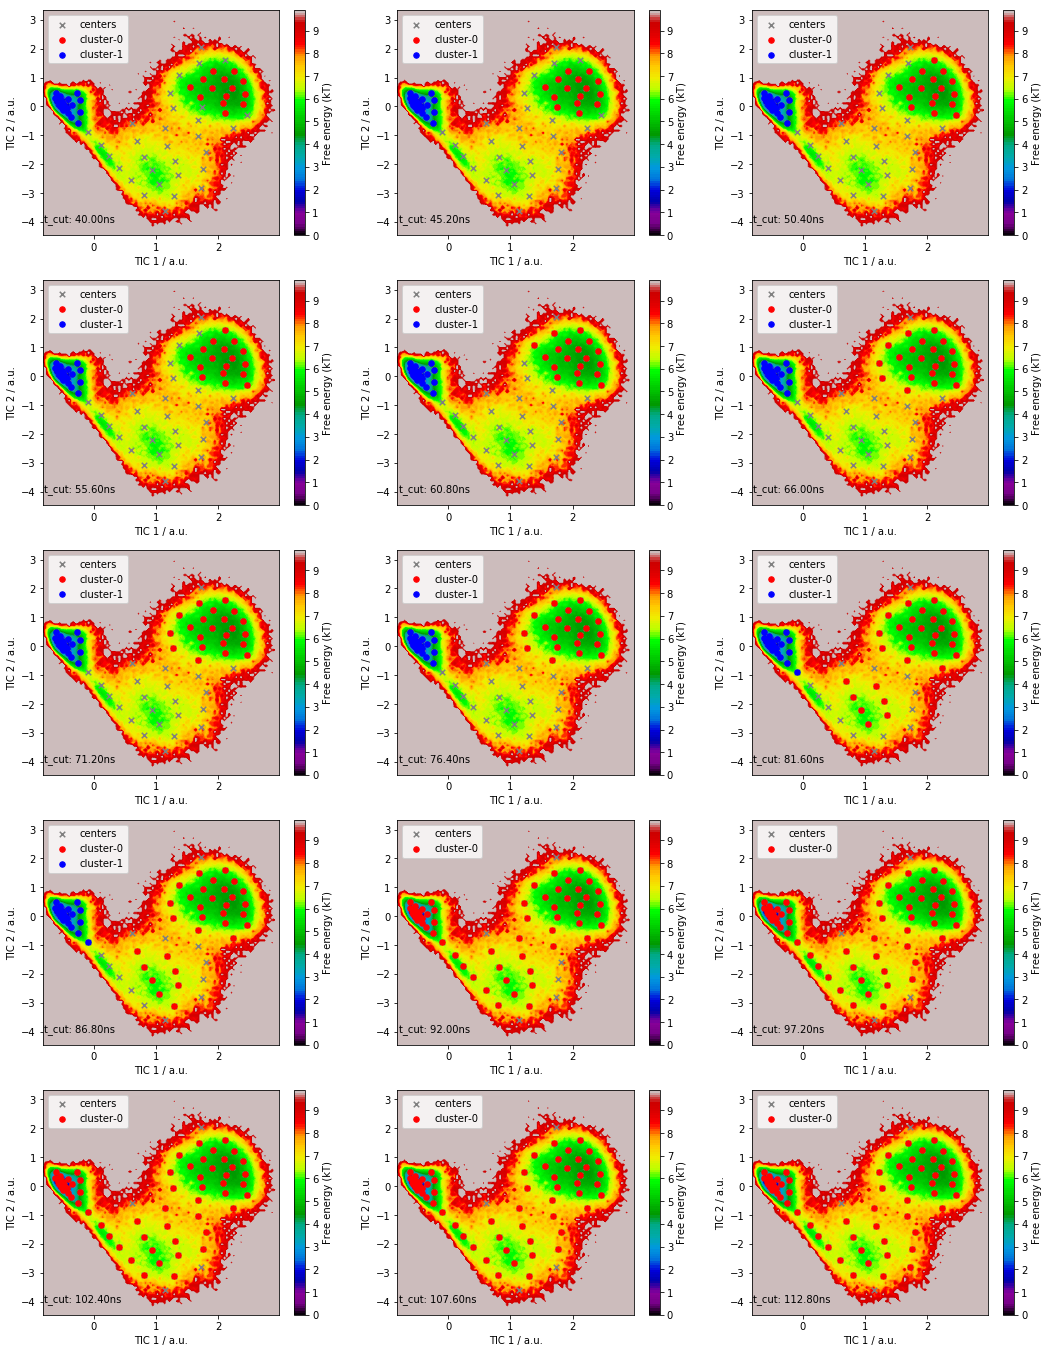

#### t_AB plots:

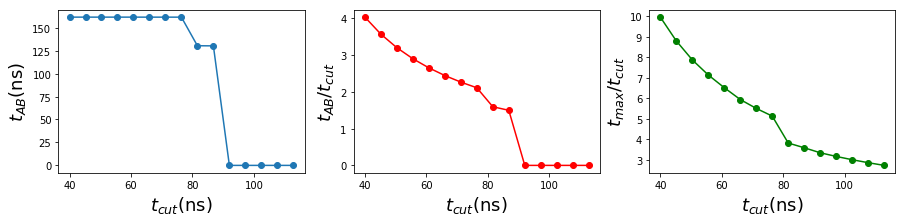

In [6]:
for k, index in enumerate(lag_index):
    K = msm[index].P
    dt = 0.2
    #---------------------
    printmd("### Lag-time: "+str(dt)+"ns")

    t_min_list=[]
    t_max_list=[]
    t_AB_list=[]

    big_clusters_list = []

    # t_cut range
    min_ = range_per_lag[k][0]
    max_ = range_per_lag[k][1]
    interval = (max_ - min_)//15 
    t_cut_values =  [min_+i for i in range(0,max_- min_,interval)][0:15]


    fig_n_cols = 3
    fig_n_rows = int(math.ceil(len(t_cut_values)/fig_n_cols))


    fig = plt.figure(figsize=(6*fig_n_cols, 4.8*fig_n_rows))

    printmd("#### t_values:")
    for ii, t_cut in enumerate(t_cut_values):

        big_clusters=[]
        big_clusters_index =[]

        # clustering
        clusters, t_min, t_max, clustered_tmatrix = kinetic_clustering_from_tmatrix(K, t_cut=t_cut, verbose=False)

        t_min_list.append(t_min)
        t_max_list.append(t_max)

        for i, cluster_i in enumerate(clusters):
            if len(cluster_i) > 1:
                big_clusters.append(cluster_i)
                big_clusters_index.append(i)

        n_big = len(big_clusters)

        macrostates = biggest_clusters_indexes(big_clusters, n_pick=2)
        #macrostates_list.append([ clusters[macrostates[i]] for i in range(len(macrostates))])
        big_clusters_list.append(big_clusters)

        if n_big > 1:
            tAB = markov_commute_time(clustered_tmatrix,[macrostates[0]],[macrostates[1]] )
        else:
            tAB = 0.0
        t_AB_list.append(tAB)

        print("t_cut: {:.2f}ns, t_min: {:.2f}ns, t_max: {:.2e}ns, tAB: {:.2f}ns".format(t_cut*dt, t_min*dt, t_max*dt, tAB*dt))

        plt.subplot(fig_n_rows, fig_n_cols, ii+1)
        pyemma.plots.plot_free_energy(*tica.T)
        plt.scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
        plt.annotate("t_cut: {:.2f}ns".format(t_cut*dt), xy=(-0.8,-4))

        colors = ['red','blue','green','black','orange']

        for i, cluster_i in enumerate(big_clusters):
            cluster_i_tica_xy = []
            for index in cluster_i:
                cluster_i_tica_xy.append(cluster.clustercenters[index])
            cluster_i_tica_xy = np.array(cluster_i_tica_xy)
            plt.scatter(*cluster_i_tica_xy.T, marker='o', c=colors[i], s=30, label='cluster-'+str(i))

        plt.legend(loc='upper left')
        plt.xlabel('TIC 1 / a.u.')
        plt.ylabel('TIC 2 / a.u.')
    printmd("#### Observed clusters vs t_cut")
    plt.show()

    printmd("#### t_AB plots:")
    plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list)

#     printmd("#### RMSD of the Macrostates:")
#     plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs=cluster.dtrajs)

### Selecting t_cut = 71ns for mfpts calculations

In [7]:
dt = 0.0002 # in micro-sec

if 0 in big_clusters_list[6][1]:
    stateA = big_clusters_list[6][0]  #Unfolded
    stateB = big_clusters_list[6][1]  #Folded
else:
    stateA = big_clusters_list[6][1]  #Unfolded
    stateB = big_clusters_list[6][0]  #Folded

lag_to_use = lags[0:16:2]

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

# my_msm_mfptAB = np.asarray([markov_mfpts(msm[lag_index[i]].P, stateA, stateB)['mfptAB']*dt for i in range(len(lag_to_use))])
# my_msm_mfptBA = np.asarray([markov_mfpts(msm[lag_index[i]].P, stateA, stateB)['mfptBA']*dt for i in range(len(lag_to_use))])

# printmd("### My Markov mfpts vs Pyemma mfpts (A->B)(us)")
# print(my_msm_mfptAB)
# print(msm_mfptAB)

# printmd("### My Markov mfpts vs Pyemma mfpts (B->A)(us)")
# print(my_msm_mfptBA)
# print(msm_mfptBA)

## Empirical and non-Markovian estimates

In [8]:
dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

std_errAB = []
std_errBA = []

for i, lag in enumerate(lag_to_use):
    
    nm_model = NonMarkovModel(cluster.dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    nm_kinetics = nm_model.mfpts()
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 109/109
Number of A->B/B->A  events: 53/53
Number of A->B/B->A  events: 44/44
Number of A->B/B->A  events: 44/43
Number of A->B/B->A  events: 38/37
Number of A->B/B->A  events: 37/36
Number of A->B/B->A  events: 31/30
Number of A->B/B->A  events: 31/30


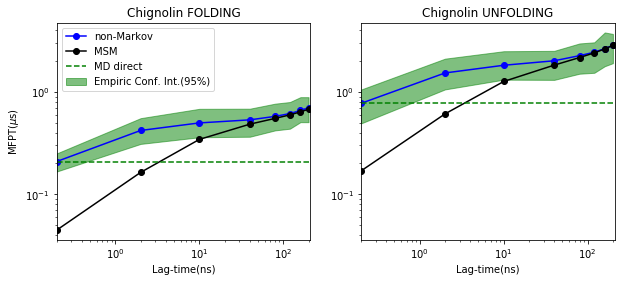

In [9]:
lag_to_use_ns = np.array(lag_to_use) * 0.2

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)


fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empiric Conf. Int.(95%)" )
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="non-Markov", c='b')
ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
#ax1.plot(lag_to_use_ns, lag_to_use_ns/nm_model.popA/1000, c='purple')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag-time(ns)")
ax1.set_ylabel("MFPT($\mu$s)")
ax1.set_xlim(0,210)
plt.legend(loc='upper left')

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empiric Conf. Int.(95%)" )
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="non-Markov", c='b' )
ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")
#ax2.plot(lag_to_use_ns, lag_to_use_ns/nm_model.popB/1000, color='purple')
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag-time(ns)")
ax2.set_xlim(0,210)
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()

## Markov + Color : History Analysis (Lag=1tau)

In [10]:
dt =0.0002

discrete_traj = cluster.dtrajs

history = np.array([0, 1, 10, 50, 100, 200, 300, 400, 500])
mpc_mfptsAB = []
mpc_mfptsBA = []

for hist in history:
    model = MarkovPlusColorModel(discrete_traj, stateA, stateB, hist_length=hist)
    kinetics = model.mfpts()
    mpc_mfptsAB.append(kinetics['mfptAB']*dt)
    mpc_mfptsBA.append(kinetics['mfptBA']*dt)

# Empirical values:
emp_mfpts = model.empirical_mfpts()

emp_mfptAB = emp_mfpts['mfptAB']*dt
emp_mfptBA = emp_mfpts['mfptBA']*dt
emp_std_err_mfptAB = emp_mfpts['std_err_mfptAB']*dt
emp_std_err_mfptBA = emp_mfpts['std_err_mfptBA']*dt

Number of A->B/B->A  events: 109/109


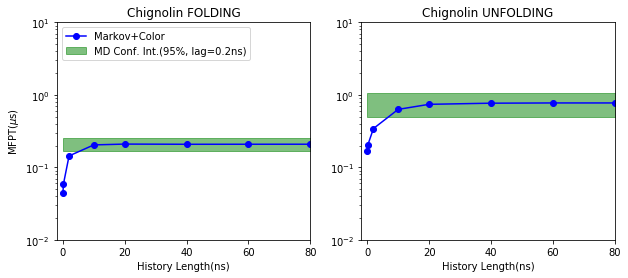

In [11]:
alpha = 0.5

fig =plt.figure(figsize = (10,4))

err_maxAB = [emp_mfptAB + 2*emp_std_err_mfptAB for _ in history]
err_minAB = [emp_mfptAB - 2*emp_std_err_mfptAB for _ in history]
err_maxBA = [emp_mfptBA + 2*emp_std_err_mfptBA for _ in history]
err_minBA = [emp_mfptBA - 2*emp_std_err_mfptBA for _ in history]

ax1 = fig.add_subplot(121)
ax1.fill_between(history*0.2, err_minAB, err_maxAB,
                 alpha=alpha, color="green", label="MD Conf. Int.(95%, lag=0.2ns)" )
ax1.plot(history*0.2, mpc_mfptsAB, "-o", label="Markov+Color", color='b')
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("History Length(ns)")
ax1.set_ylabel("MFPT($\mu$s)")
ax1.legend(loc='upper left')
ax1.set_xlim(-2,80)
ax1.set_ylim(0.01,10)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(history*0.2, err_minBA, err_maxBA,
                 alpha=alpha, color="green", label="Conf. Int.(95%)" )
ax2.plot(history*0.2, mpc_mfptsBA, "-o", label="Markov+Color", color='b')
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("History Length(ns)")
#ax2.legend(loc='upper left')
ax2.set_xlim(-2,80)
ax2.set_ylim(0.01,10)

plt.show()

## First Passage Time Distribution

In [12]:
nm_model2 = NonMarkovModel(cluster.dtrajs, stateA, stateB)
nm_model2.mfpts() ## This values has to be multiplied by dt = 0.2ns

{'mfptAB': 1041.6723745669497, 'mfptBA': 3864.2752601526536}

In [13]:
lag_to_use_fptd = [1, 10, 100, 1000]

In [14]:
fptdAB = nm_model2.fpt_distrib_AB(max_x=5000, dt=0.2)  # Computes the analytic dist. up to 5000 lag times
fptdBA = nm_model2.fpt_distrib_BA(max_x=10000, dt=0.2)
empiric_fptsAB, empiric_fptsBA, tb_values = nm_model2.empirical_fpts()

In [15]:
#Markov densities
nm_model2.markovian=True

markov_fptdAB_list=[]
markov_fptdBA_list=[]

for lag in lag_to_use_fptd:
    nm_model2.lag_time=lag
    markov_fptdAB_list.append(nm_model2.fpt_distrib_AB(max_x=5000, dt=0.2))
    markov_fptdBA_list.append(nm_model2.fpt_distrib_BA(max_x=10000, dt=0.2))

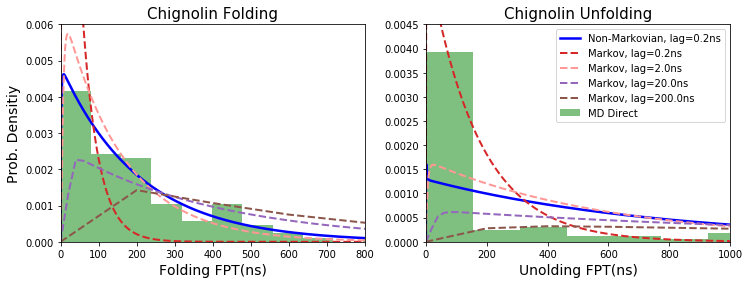

In [16]:
fig =plt.figure(figsize = (12,4))

ax1 = fig.add_subplot(121)
ax1.plot(*fptdAB.T,label='Non-Markovian, lag=0.2ns', color='b',lw=2.5)

for i, density in enumerate(markov_fptdAB_list):
    ax1.plot(*density.T,'--', linewidth=2.0, color=color_sequence[i],
             label='Markov, lag={}ns'.format(lag_to_use_fptd[i]*0.2) )



ax1.hist(np.array(empiric_fptsAB)*0.2, normed=True, bins=20, label='MD Direct', color='green', alpha=0.5)
ax1.set_ylabel("Prob. Densitiy", fontsize=14)
ax1.set_xlabel("Folding FPT(ns)", fontsize=14)
ax1.set_xlim([0,800])
ax1.set_ylim(0,0.006)
ax1.set_title('Chignolin Folding', fontsize=15)


ax2 = fig.add_subplot(122)
ax2.plot(*fptdBA.T,label='Non-Markovian, lag=0.2ns',lw=2.5, color='b')

for i, density in enumerate(markov_fptdBA_list):
    ax2.plot(*density.T,'--', linewidth=2.0, color=color_sequence[i],
             label='Markov, lag={}ns'.format(lag_to_use_fptd[i]*0.2) )

ax2.hist(np.array(empiric_fptsBA)*0.2, normed=True, bins=50, label='MD Direct', color='green', alpha=0.5)
ax2.set_xlabel("Unolding FPT(ns)", fontsize=14)
ax2.set_xlim([0,1000])
ax2.set_ylim(0,0.0045)
ax2.set_title('Chignolin Unfolding', fontsize=15)
ax2.legend()

fig.tight_layout

plt.show()

## Event duration ($t_b$)

###  Average $t_b$ = 10.30ns

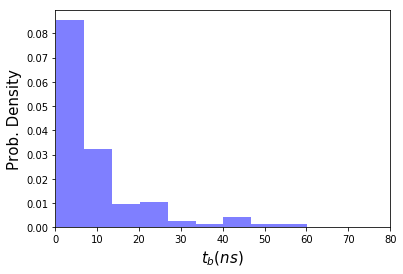

In [17]:
printmd("###  Average $t_b$ = {:.2f}ns".format(0.2*sum(tb_values)/len(tb_values)))

plt.hist(np.array(tb_values)*0.2, normed=True, bins=20, color='blue', alpha=0.5)
plt.xlabel("$t_b (ns)$", fontsize=15)
plt.ylabel("Prob. Density", fontsize=15)
plt.annotate
plt.xlim([0,80])
plt.show()

## Correlation functions

In [18]:
times =  range(200, 8000, 200)
times_in_us = np.array(times)*0.0002

emp_coorAB = nm_model.empirical_corr_function(nm_model.stateA, nm_model.stateB, times=times)
emp_coorAA = nm_model.empirical_corr_function(nm_model.stateA, nm_model.stateA, times=times)
emp_coorBB = nm_model.empirical_corr_function(nm_model.stateB, nm_model.stateB, times=times)

                                              LAG TIME: 0.2ns


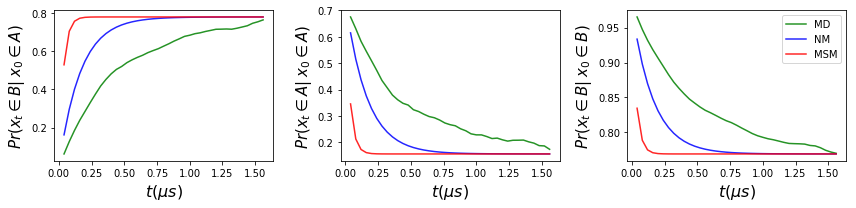

                                              LAG TIME: 2.0ns


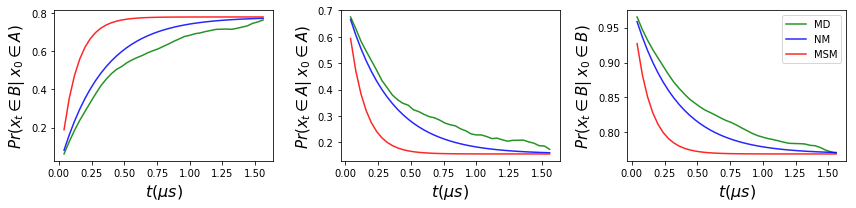

                                              LAG TIME: 10.0ns


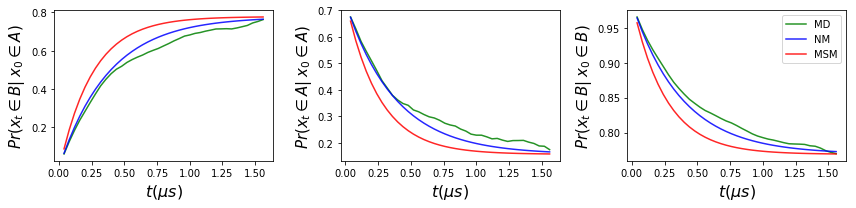

                                              LAG TIME: 20.0ns


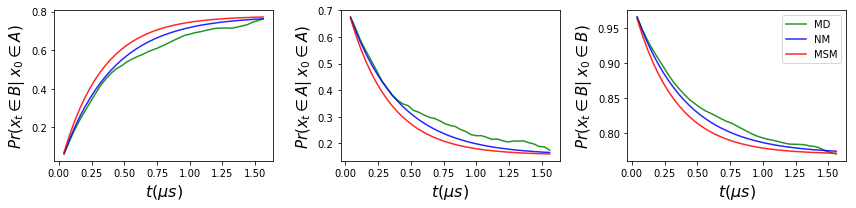

                                              LAG TIME: 40.0ns


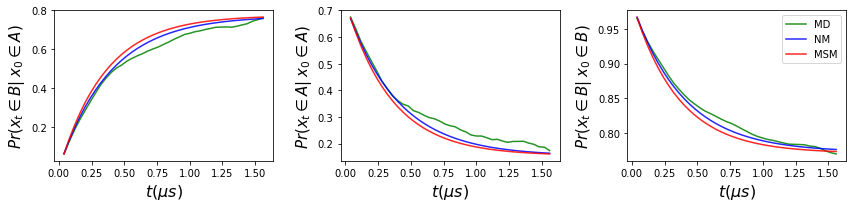

In [25]:
pA = nm_model.popA
pB = nm_model.popB

alpha = 0.85

for lag in [1, 10, 50, 100, 200]:

    nm_model.lag_time=lag
    print(46*' ' + 'LAG TIME: {}ns'.format(lag*0.2))

    nm_pAA, nm_pAB, nm_pBA, nm_pBB = nm_model.corr_function(times=times)
    
    nm_model.markovian = True
    msm_pAA, msm_pAB, msm_pBA, msm_pBB = nm_model.corr_function(times=times)
    nm_model.markovian = False

    fig = plt.figure(figsize=(12,3))
    fig.add_subplot(131)
    plt.plot(times_in_us, emp_coorAB/pA, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pAB/pA, label='NM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pAB/pA, label='MSM', color='red', alpha=alpha)
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in B|\; x_0 \in A)$', fontsize=15)

    fig.add_subplot(132)
    plt.plot(times_in_us, emp_coorAA/pA, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pAA/pA, label='NM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pAA/pA, label='MSM', color='red', alpha=alpha)
    
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in A|\; x_0 \in A)$', fontsize=15)
    
    fig.add_subplot(133)
    plt.plot(times_in_us, emp_coorBB/pB, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pBB/pB, label='NM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pBB/pB, label='MSM', color='red', alpha=alpha )
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in B|\; x_0 \in B)$', fontsize=15)
    plt.legend(loc='upper right')

    fig.tight_layout()

    plt.show()